In [128]:
from astropy.io import fits
import clevar
import pandas as pd
from astropy.table import Table
import astropy
from matplotlib import pyplot as plt
import numpy as np
from numcosmo_py import Ncm, Nc
from numcosmo_py.external.pyssc import pyssc as PySSC
Ncm.cfg_init()

In [132]:
table_richness_all = Table.read('richness_mcut_SNR 12_ame.fits', format='fits')
table_halos_all  = Table.read('halos.fits', format='fits')
import astropy.units as u
table_richness = table_richness_all[table_richness_all["z"] < 0.213]
table_halos = table_halos_all[table_halos_all["M200c"]>13]
table_halos_df = table_halos.to_pandas()


print(table_halos_df.columns)
print(table_richness.columns)

catalog_halos = clevar.ClCatalog('Halo catalog', id=table_halos_df['id'],ra=table_halos_df['RA'] ,dec=table_halos_df['DEC'] ,z=table_halos_df['redshift_R'], mass=table_halos_df['M200c'])
catalog_richness = clevar.ClCatalog('Detection catalog', id=table_richness['ID'], ra=table_richness['RA'], dec=table_richness['DEC'], z=table_richness['z'], mass=table_richness['R_ame'])

table_richness.sort(['RA'])
table_halos.sort(['RA'])

#table_richness.sort(['DEC'])
#table_halos.sort(['DEC'])

display(table_halos)
display(table_richness)



Index(['id', 'pid', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'M200c', 'M500c', 'Mvir',
       'Mvir_all', 'Rvir', 'rs', 'Spin', 'Spin_Bullock', 'Xoff', 'b_to_a',
       'c_to_a', 'scale_of_last_MM', 'T_U', 'RA', 'DEC', 'g_lat', 'g_lon',
       'redshift_R', 'redshift_S'],
      dtype='object')
<TableColumns names=('ID','RA','DEC','z','z_err','SNR','SNR_ORIG','richness','radius','rank','Rc','R_ame','R_ame_err')>


id,pid,x,y,z,vx,vy,vz,M200c,M500c,Mvir,Mvir_all,Rvir,rs,Spin,Spin_Bullock,Xoff,b_to_a,c_to_a,scale_of_last_MM,T_U,RA,DEC,g_lat,g_lon,redshift_R,redshift_S
,,Mpc,Mpc,Mpc,km / s,km / s,km / s,log10(M[Msun/h]),log10(M[Msun/h]),log10(M[Msun/h]),log10(M[Msun/h]),kpc / h,kpc / h,,,kpc / h,,,,,deg,deg,deg,deg,,
int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64
219833693848697,-1,-650.70874,-0.19189453,-169.7815,-22.1,-62.18,-42.99,13.046612,12.925333,13.096562,13.096598,495.433,51.428,0.01071,0.0104,12.4078,0.59552,0.43323,0.0874,0.5738,0.016906738,14.623459,-46.426868326958484,104.75060857773315,0.1578771747133714,0.15798474538046556
233611955840845,-1,-550.4724,-0.20678711,-92.92871,208.92,-358.95,-322.01,13.114978,13.009153,13.163161,13.163072,521.364,51.455,0.02745,0.02566,7.80758,0.67774,0.59988,0.3159,0.5481,0.021530151,9.582108,-51.235898521950354,102.44911599676539,0.13015402324693262,0.12964619762460305
233577592804150,-1,-571.8926,-0.26586914,-238.05737,-66.39,-101.72,164.94,13.101541,12.951099,13.154424,13.157154,517.96,82.778,0.0468,0.0526,33.3578,0.88846,0.68343,0.36084,0.6381,0.026641846,22.60012,-38.747478326309825,107.68875120488991,0.14495646944811238,0.14494963143555925
219868048918676,-1,-599.3801,-0.29516602,-109.093506,300.05,236.08,243.28,13.188704,12.702741,13.317645,13.317959,587.082,476.39,0.07656,0.17324,215.179,0.23406,0.13973,0.87529,0.8781,0.02822876,10.315514,-50.541510432055105,102.82343210973062,0.1424732065157523,0.14134315917456583
219833693848844,-1,-656.407,-0.38378906,-158.04565,-208.93,-176.24,-219.89,13.142201,12.957555,13.207904,13.214844,539.606,92.516,0.02986,0.03096,13.5046,0.76517,0.58118,0.20281,0.5651,0.0335083,13.537651,-47.47080527382991,104.3125022810832,0.15853058841710185,0.1593803578893953
260996662258180,-1,-164.33423,-0.103271484,-544.10986,5.31,190.57,-20.32,13.009196,12.79554,13.128722,13.134049,507.786,151.893,0.05975,0.06917,45.8211,0.59793,0.49254,0.20281,0.6025,0.035995483,73.19441,10.696656729922298,119.1875269696337,0.132594736432154,0.1326543823590413
247252770018475,-1,-324.5349,-0.20678711,-551.88965,86.09,-113.51,274.66,13.002685,12.843992,13.080266,13.081203,489.331,109.053,0.07531,0.08821,17.0314,0.92897,0.65304,0.6142,0.6422,0.036499023,59.542633,-2.683586292396627,116.46532308165757,0.1500080117090164,0.14907307507658568
261065381893087,-1,-263.69946,-0.25097656,-217.71484,152.32,-77.06,161.21,13.15048,12.9701,13.305996,13.305996,573.0,168.811,0.03578,0.04475,63.1046,0.48748,0.43865,0.70146,0.6622,0.054534912,39.543655,-22.26726880590453,112.28932381658758,0.07872476648335539,0.07799087798964444


ID,RA,DEC,z,z_err,SNR,SNR_ORIG,richness,radius,rank,Rc,R_ame,R_ame_err
int16,float64,float64,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64
16061,110.00592219542078,56.89078323205376,0.1813836934931291,0.001383693493129,13.242740269456345,22.50289999636517,0.0143562106563032,13.242740269456345,185651,450.0,26.0,2.0802637268705464
3581,110.00645807931038,65.1502579503857,0.2067796265157541,0.006779626515754,18.184663979898303,35.59476307082334,0.0237080597023852,18.184663979898303,52290,450.0,19.0,2.209571807688841
15838,110.00759715394916,50.81655802821695,0.12605322220163,0.00605322220163,13.285812545783234,21.41383525479339,0.0116838685392728,13.285812545783234,268715,450.0,21.0,2.818689132676157
5486,110.00871648255838,61.21439965771334,0.1922135519235636,0.0022135519235636,16.763907575921145,31.482237544128736,0.0205677835714109,16.763907575921145,79470,450.0,29.06,2.020576815334341
20194,110.01952673512056,51.47223252242348,0.1218267757329522,0.0018267757329522,12.513480432513198,19.77416242426398,0.0107892234170236,12.513480432513198,305970,450.0,36.0,2.159464131059679
12533,110.03234824697404,31.290353906651166,0.0963609853043938,0.0063609853043938,14.03513901799664,22.3436060567404,0.0111067145050075,14.03513901799664,291949,450.0,21.0,2.7269428254610206
899,110.04710599904968,59.69304929018375,0.1838613699705394,0.0038613699705394,23.269852734829875,49.77508784752387,0.031755084664332,23.269852734829875,16278,450.0,46.0,2.568413175484038
110,110.05241804296448,63.50065836166778,0.0803391479961261,0.0103391479961261,30.802393340668694,65.14431535538445,0.0305686796793912,30.802393340668694,18748,450.0,56.0,2.055553777777009
14378,110.07495840688472,27.92658598190744,0.1826726363984803,0.0026726363984802,13.58903906300418,23.320279646552954,0.0148776754404254,13.58903906300418,173297,450.0,73.29999999999998,1.9584487466700105


In [130]:
mt = clevar.match.ProximityMatch()

match_config = {
    'type': 'cross', # options are cross, cat1, cat2
    'which_radius': 'max', # Case of radius to be used, can be: cat1, cat2, min, max
    'preference': 'angular_proximity', # options are more_massive, angular_proximity or redshift_proximity
    'catalog1': {'delta_z':.2,
                'match_radius': '1 mpc'
                },
    'catalog2': {'delta_z':.2,
                'match_radius': '10 arcsec'
                }
}

cosmo = clevar.cosmology.AstroPyCosmology()
mt.match_from_config(catalog_halos, catalog_richness, match_config, cosmo=cosmo)


## ClCatalog 1
## Prep mt_cols
### Prep z_cols
* zmin|zmax from config value
### Prep ang_cols
* ang radius from set scale

## ClCatalog 2
## Prep mt_cols
### Prep z_cols
* zmin|zmax from config value
### Prep ang_cols
* ang radius from set scale

## Multiple match (catalog 1)
Finding candidates (Halo catalog)
* 0/19,752 objects matched.ates

## Multiple match (catalog 2)
Finding candidates (Detection catalog)
* 0/5,807 objects matched.tes

## Finding unique matches of catalog 1
Unique Matches (Halo catalog)


KeyboardInterrupt: 

In [3]:
area = 4109.3
cosmo = Nc.HICosmoDEXcdm()
cosmo.param_set_by_name("H0", 67.74)
cosmo.param_set_by_name("Omegab", 0.0486)
cosmo.param_set_by_name("Omegax", 0.6911)
cosmo.param_set_by_name("Omegac", 0.2603)
cosmo.param_set_by_name("w", -1.0)


prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA", 3.02745)
prim.param_set_by_name("n_SA", 0.9667)

reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFuncEH()

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()

mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200.0)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.set_area(area * (np.pi / 180) ** 2)
hmf.prepare(cosmo)
hbias_Tinker = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf, None)
cad.set_area(area * (np.pi / 180) ** 2)
hmf.prepare(cosmo)

#σ_8 = 0.8159

In [4]:
#mass proxy
cluster_m = Nc.ClusterMassRichness(richnessobs_min = 1.0 ,richnessobs_max = 1000.0 ,M0=np.exp(13.0*np.log(10)))
cluster_m.param_set_by_name("mu", 1.507) #1.3928
cluster_m.param_set_by_name("mum",0.993) #0.86859
cluster_m.param_set_by_name("muz", 0)
cluster_m.param_set_by_name("mumz", 0)
cluster_m.param_set_by_name("sigma0",0.456)

cluster_m.set_property("mu_fit", True)
cluster_m.set_property("mum_fit", True)
cluster_m.set_property("sigma0_fit", True)

#photo-z
cluster_z = Nc.ClusterPhotozGauss (pz_min = 0.0 , pz_max = 0.7)

print("\n")
print(cluster_m.p(cosmo , 35.45, 0.1 , [35.46546] , [1.175]))
print(cluster_m.intp(cosmo , 36 , 0.1))
print(cluster_m.intp_bin(cosmo , 30.45 , 0.1 , [1] , [100] , [2.90969]))
print("\n")

print(cluster_z.p(cosmo , 32 , 0.66 , [0.657513] , [0,0.007513]))
print(cluster_z.intp(cosmo , 32 , 0.9))
print(cluster_z.intp_bin(cosmo , 32 , 0.9, [0.8] , [1.0] , [0,0.0513]))
print("\n")



1.800982074393811e-14
0.0858742729734331
0.956685133740931


50.26920750570403
0.00022509038284751481
0.9487425085333445




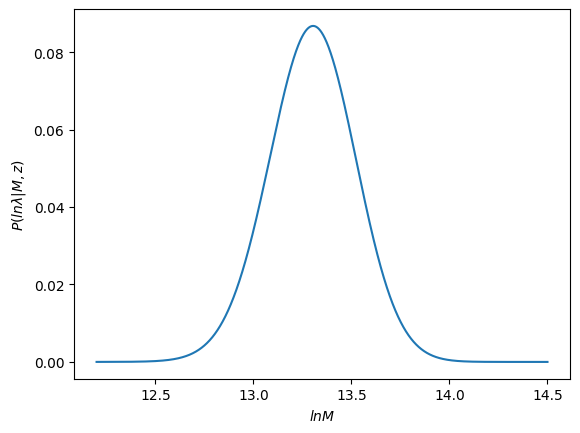

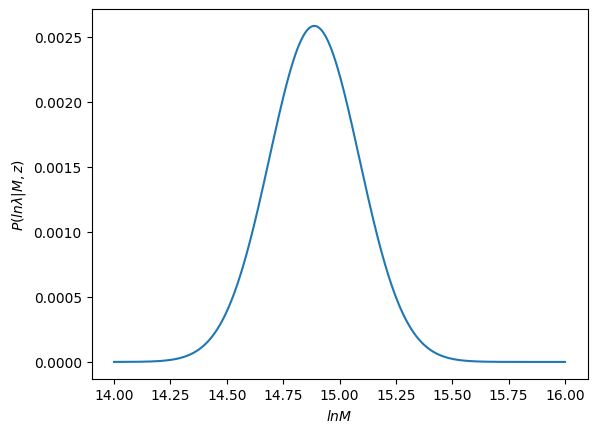

In [5]:
masses  = np.linspace(np.log(10) *12.2 , np.log(10) * 14.5,10000)
masses_10  = np.linspace(12.2 ,14.5,10000)
relation = []

for i in range(len(masses)):
    relation.append(cluster_m.p(cosmo , masses[i], 0.1 , [9.52] , [1.826111]))
plt.plot(masses_10 , relation)
plt.ylabel(r'$P(ln\lambda|M,z)$')
plt.xlabel(r'$lnM$')
plt.show()

masses  = np.linspace(np.log(10) *14.0, np.log(10) * 16  ,10000)
masses_10  = np.linspace(14.0 ,16    ,10000)
relation = []

for i in range(len(masses)):
    relation.append(cluster_m.p(cosmo , masses[i], 0.1 , [338.48] , [1.942005]))
plt.plot(masses_10 , relation)
plt.ylabel(r'$P(ln\lambda|M,z)$')
plt.xlabel(r'$lnM$')
plt.show()

In [ ]:

mset = Ncm.MSet.new_array([cosmo, cluster_m, cluster_z])
ncdata = Nc.DataClusterNCount.new(cad, "NcClusterPhotozGauss", "NcClusterMassRichness")
ncdata.set_init(True)

bin_test =  catalog_richness_df.query(' R_ame >= 0  & R_ame <= 100')
display(bin_test["R_ame"].sort_values())

richness = np.array(bin_test['R_ame'])
redshift = np.array(bin_test['z'])
redshift_err = np.array(bin_test['z_err'])
richness_err = np.array(bin_test['R_ame_err'])

z_obs_params = Ncm.Matrix.new(len(redshift_err), 2)
lnM_obs_params = Ncm.Matrix.new(len(richness_err), 1)
for i in range(len(redshift_err)):
    lnM_obs_params.set(i , 0 ,richness_err[i] )
    for j in range(0, 2):
        if j == 0:
            z_obs_params.set(i, j, 0)
        if j == 1:
            z_obs_params.set(i, j,  redshift_err[i])
print(richness) 

ncdata.set_lnM_obs(Ncm.Matrix.new_array(richness, 1))
ncdata.set_z_obs(Ncm.Matrix.new_array(redshift, 1))
ncdata.set_z_obs_params(z_obs_params)
ncdata.set_lnM_obs_params(lnM_obs_params)
ncdata.true_data(False)

dset = Ncm.Dataset.new_array([ncdata])
likelihood = Ncm.Likelihood.new(dset)

experiment = Ncm.ObjDictStr()
experiment.set("likelihood", likelihood)
experiment.set("model-set", mset)
ser = Ncm.Serialize.new(Ncm.SerializeOpt.CLEAN_DUP)
ser.dict_str_to_yaml_file(experiment, "unbinned.yaml")

ca =[]
lnM_obs = ncdata.get_lnM_obs()
z_obs = ncdata.get_z_obs()
z_obs_params = ncdata.get_z_obs_params()



rich = np.linspace(5.76, 100 , 100)
redshift = np.linspace(0.0, 0.7 , 2)
rich_plot = []
cad.prepare(cosmo , cluster_z , cluster_m)
cad.set_area(area * (np.pi / 180) ** 2)
print(cad.n(cosmo , cluster_z , cluster_m))
halo = []
for i in range(len(rich)-1):
    z = []
    z_err = []
    r = []
    r_err = []
    bin_test =  catalog_richness_df.query(' R_ame >= %f   & R_ame <= %f  &  z >= %f  & z <= %f' % (rich[i] , rich[i+1] , 0 , 0.7))
    
    for j in range(len(bin_test['R_ame'])):
        r.append(bin_test['R_ame'].values[j] *bin_test['R_ame_err'].values[j])
        z.append(bin_test['z'].values[j] *bin_test['z_err'].values[j])
    
    mean_r = sum(r)/bin_test['R_ame_err'].sum()
    mean_z = sum(z)/bin_test['z_err'].sum()

    for j in range(len(bin_test['R_ame'])):
        r_err.append(bin_test['R_ame_err'].values[j] *(bin_test['R_ame'].values[j]- mean_r)**2)
        z_err.append(bin_test['z_err'].values[j]*(bin_test['z'].values[j] - mean_z)**2)
    
    sigma_r = np.sqrt(sum(r_err)/bin_test['R_ame_err'].sum())
    sigma_z = np.sqrt(sum(z_err)/bin_test['z_err'].sum())
    halo.append(cad.intp_bin_d2n(cosmo  , cluster_z , cluster_m  ,[rich[i]] , [rich[i+1]] , [sigma_r],[0.0] , [0.7] , [0 , sigma_z]))
    rich_plot.append((rich[i]+rich[i+1])/2)

2763       5.76
3848       6.00
10492      9.52
18130      9.80
23410     10.00
          ...  
20       260.96
429      269.22
0        273.00
10       282.74
174      338.48
Name: R_ame, Length: 23751, dtype: float64

[273.   231.   170.   ...  45.46  50.4   55.6 ]
5807947.998255762



(process:1019312): NUMCOSMO-WARNING **: 16:42:32.188: ncm_integrate_2dim: number of evaluations 10000055 >= maximum number of evaluations 10000000 (nregions 76924, fail 1, result                   -nan, error   2.52621157545206e-48).

/tmp/ipykernel_1019312/3254880769.py:64: RuntimeWarning: invalid value encountered in scalar divide
  mean_r = sum(r)/bin_test['R_ame_err'].sum()
/tmp/ipykernel_1019312/3254880769.py:65: RuntimeWarning: invalid value encountered in scalar divide
  mean_z = sum(z)/bin_test['z_err'].sum()
/tmp/ipykernel_1019312/3254880769.py:71: RuntimeWarning: invalid value encountered in scalar divide
  sigma_r = np.sqrt(sum(r_err)/bin_test['R_ame_err'].sum())
/tmp/ipykernel_1019312/3254880769.py:72: RuntimeWarning: invalid value encountered in scalar divide
  sigma_z = np.sqrt(sum(z_err)/bin_test['z_err'].sum())


In [ ]:
plt.hist(bin_test['R_ame'] , bins=100)
plt.plot(rich_plot , halo)
plt.xlim(0 , 100)
plt.yscale("log")

plt.show()